# Overlay rails map with area of interest

Notes on the rail buffering:
- round style prevents breaks in the buffers
- USA uses standard track guage (https://en.wikipedia.org/wiki/Track_gauge_in_the_United_States), which is about 1.5m wide

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, box, LineString
from shapely import intersection
from tqdm.notebook import tqdm

target_epsg = 6350  # https://epsg.org/crs_6350/NAD83-2011-Conus-Albers.html?sessionkey=nb47agmo4r

In [2]:
fn_aoi = '/Volumes/Extreme SSD/largest_plots/clean_data/aoi.parquet'
fn_rails = '/Volumes/Extreme SSD/largest_plots/raw_data/tl_2023_us_rails.zip'
fn_rail_overlay = '/Volumes/Extreme SSD/largest_plots/clean_data/rails_overlay.parquet'

In [3]:
Aoi = gpd.read_parquet(fn_aoi).set_geometry('aoi').set_crs(epsg=target_epsg)
Rails = gpd.read_file(fn_rails).to_crs(epsg=target_epsg)

# Transform linear rails to polygons

In [4]:
RailPolygons = Rails[['geometry']].buffer(distance=0.75, cap_style='round')
RailPolygons = RailPolygons.to_frame().rename(columns={0:'geometry'})
RailPolygons.set_geometry('geometry', inplace=True)
RailPolygons.head()

,geometry
0,"POLYGON ((1480145.928 1505645.640, 1480145.934..."
1,"POLYGON ((1480270.626 1505901.408, 1480270.611..."
2,"POLYGON ((1480369.404 1506230.074, 1480446.390..."
3,"POLYGON ((1489683.637 1470829.123, 1489691.628..."
4,"POLYGON ((1486906.929 1462856.479, 1486906.930..."


In [5]:
RailPolygons.shape[0] == Rails.shape[0]

True

In [6]:
Intersection = gpd.sjoin(
    RailPolygons, 
    Aoi, 
    how='inner', 
    predicate='intersects',
    rsuffix='aoi'
)
Intersection.head()

,geometry,index_aoi
3,"POLYGON ((1489683.637 1470829.123, 1489691.628...",179
3,"POLYGON ((1489683.637 1470829.123, 1489691.628...",29
3,"POLYGON ((1489683.637 1470829.123, 1489691.628...",182
3,"POLYGON ((1489683.637 1470829.123, 1489691.628...",34
3,"POLYGON ((1489683.637 1470829.123, 1489691.628...",33


In [7]:
FlatIntersection = Intersection.set_geometry('geometry').dissolve(by='index_aoi')
FlatIntersection.index.names = ['index']

In [8]:
RailOverlay = FlatIntersection['geometry'].intersection(Aoi['aoi'], align=True)
RailOverlay = RailOverlay.to_frame().rename(columns={0:'rail_geometry'})
RailOverlay = RailOverlay.set_geometry('rail_geometry').set_crs(epsg=target_epsg)
RailOverlay.head()

,rail_geometry
index,
0,"MULTIPOLYGON (((1600592.836 1836255.424, 16005..."
1,"MULTIPOLYGON (((1546791.621 1780605.676, 15468..."
2,"MULTIPOLYGON (((966290.042 1167967.394, 966290..."
3,"MULTIPOLYGON (((527459.803 915570.153, 527460...."
4,"MULTIPOLYGON (((1020491.262 1672079.979, 10204..."


In [9]:
# QC-- are all observations accounted for?
set(Aoi.index.tolist()) == set(RailOverlay.index.tolist())

True

QC

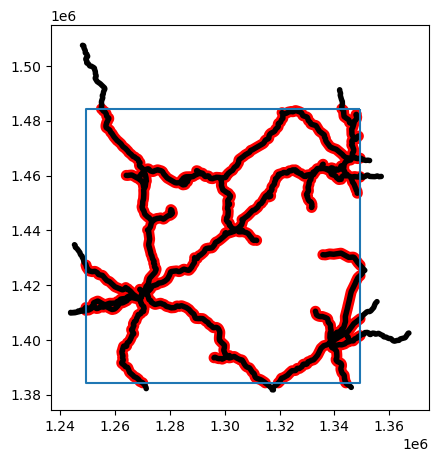

In [11]:
i = 32
fig, ax = plt.subplots(figsize=(5,5))
Aoi.loc[[i]].boundary.plot(ax=ax)
RailOverlay.loc[[i]].buffer(distance=2000).plot(ax=ax, color='red')
FlatIntersection.loc[[i]].buffer(distance=1000).plot(ax=ax, color='black')
plt.show()

In [12]:
RailOverlay.to_parquet(fn_rail_overlay)